# Airbus ship detection

## Task

Given an image of airbus ship in somekind of enviroment highlight the ship, excluding everything considered not a ship.

Image segmentation task:

![Goal_of_task](https://miro.medium.com/max/1400/1*UnnNfshGGOObJDrXKVzLQQ.png)

In our case we will have ships instead of humans))

The goal in this task as shown in the picture above, from the input image detect the boundaries of the target object and fill them with a certain color (make a mask) and give the image with the mask as output.

As for this competition the output should be a csv file with image id in first column 

## Data

We have a kaggle competition dataset which contains:
* train image folder
* test image folder
* submission csv (ImageId, EncodedPixels)
* segmentation csv (ImageId, EncodedPixels)

In [4]:
# Imports
import random
import os
import pathlib
import gc

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
import PIL.Image
%matplotlib inline

from helper_functions import rle_decode, plot_data_balance

# Setup random seed
random.seed(369)
np.random.seed(369)

In [5]:
# Set path to train/test & other folders
train_folder = pathlib.Path(r'./data/train_v2')
test_folder = pathlib.Path(r'./data/test_v2')
labels_csv = pathlib.Path(r'./data/train_ship_segmentations_v2.csv')

## EDA

In [6]:
# Get dataframe and look at first 5 rows to see how it looks
labels_df = pd.read_csv(labels_csv)
print(f'There are {len(labels_df)} observations')
labels_df.head()

There are 231723 observations


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [7]:
# Drop corrupted images
labels_df.drop(labels_df[labels_df.ImageId.isin(['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg', '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg', 'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'])].index, inplace=True)

In [8]:
labels_df.ImageId.isin(['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg', '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg', 'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'])

0         False
1         False
2         False
3         False
4         False
          ...  
231718    False
231719    False
231720    False
231721    False
231722    False
Name: ImageId, Length: 231722, dtype: bool

In [9]:
# Check data types
labels_df.dtypes

ImageId          object
EncodedPixels    object
dtype: object

In [10]:
# See if there are missing values
labels_df.isna().sum()

ImageId               0
EncodedPixels    149999
dtype: int64

In [11]:
# Specify the values of missing and all of data 
len_obs = len(labels_df.groupby(by='ImageId'))
miss_labl = labels_df.isna().sum()[1]  # Need to specify that it is [1] column, there are no missing values at the first one

There are: 192555 observations.

Missing observations: 149999

The ratio of missed data to all is: 0.7790

Number of images with ships: 42556



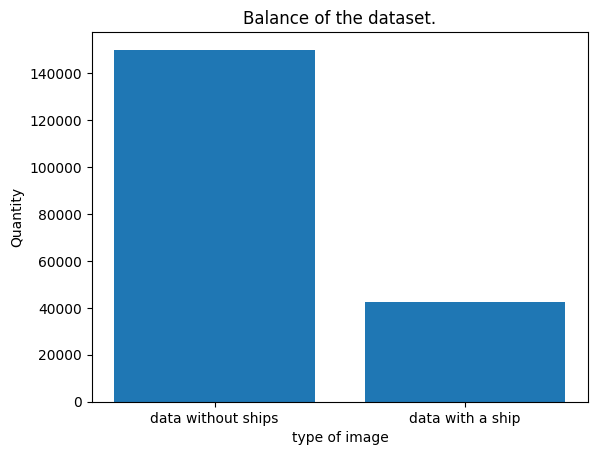

In [12]:
# Analize the number of observations and missing data 
plot_data_balance(labels_df, len_obs, miss_labl)

Dataset is unbalanced.

Data has ~78% of missing values (50% needed).

Will randomly remove 28% of the missing data values.

In [13]:
# Drop images without ships, so that number of images with and without ships are the same
labels_df = labels_df.drop(labels_df[labels_df.EncodedPixels.isna()].sample(miss_labl-(len_obs-miss_labl)).index)

In [14]:
# Create a column that shows if there is a ship on mask
labels_df.fillna(0, inplace=True)
labels_df['Ships'] = np.where(labels_df['EncodedPixels']==0, 0, 1)
labels_df.EncodedPixels.replace(0, float('Nan'), inplace=True)
labels_df

ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                NaN   
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
5       000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...   
...               ...                                                ...   
231710  fffcd0cf7.jpg                                                NaN   
231711  fffcda6d6.jpg                                                NaN   
231712  fffd924fb.jpg  110011 5 110779 5 111547 5 112315 5 113083 5 1...   
231713  fffd924fb.jpg  198440 8 199208 8 199976 8 200744 8 201512 8 2...   
231714  fffdd2377.jpg  333603 7 334359 19 335120 26 335888 26 336656 ...   

        Ships  
0           0  
2           1  
3           1  
4           1  
5           1  
...       ...  
231710      0  
231711      0  
231712      1  
231713      1  
231714      1  

[124279 rows x 3 columns]

In [15]:
# Specify the values of missing and all of data 
len_obs = len(labels_df.groupby(by='ImageId'))
miss_labl = labels_df.isna().sum()[1]  # Need to specify that it is [1] column, there are no missing values at the first one

There are: 85112 observations.

Missing observations: 42556

The ratio of missed data to all is: 0.5000

Number of images with ships: 42556



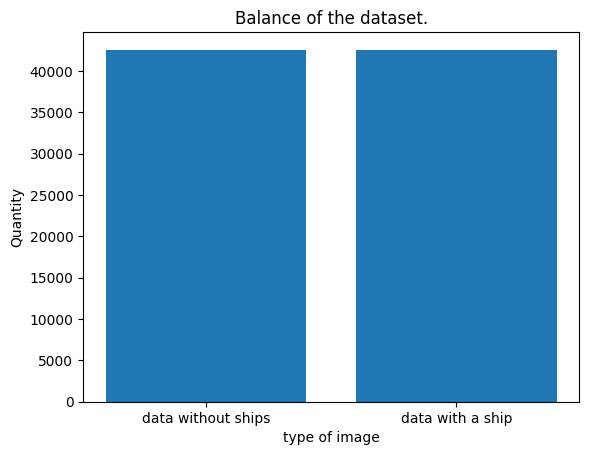

In [16]:
# plot the balance between given images
plot_data_balance(labels_df, len_obs, miss_labl)
del plot_data_balance
del len_obs
del miss_labl

In [17]:
%%time
# Decoded all the encoded pixels and replace them
labels_df['DecodedPixels'] = labels_df.EncodedPixels.apply(rle_decode)
labels_df.drop('EncodedPixels', axis=1, inplace=True)
del rle_decode
labels_df

CPU times: total: 1min 52s
Wall time: 2min 5s


ImageId  Ships  \
0       00003e153.jpg      0   
2       000155de5.jpg      1   
3       000194a2d.jpg      1   
4       000194a2d.jpg      1   
5       000194a2d.jpg      1   
...               ...    ...   
231710  fffcd0cf7.jpg      0   
231711  fffcda6d6.jpg      0   
231712  fffd924fb.jpg      1   
231713  fffd924fb.jpg      1   
231714  fffdd2377.jpg      1   

                                            DecodedPixels  
0                                                     NaN  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                   ...  
231710                                                NaN  
231711                                                NaN  
231712  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
231713  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
231714  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[124279 rows x 3 columns]

In [18]:
# Force garbage collector to release unrefferenced memory
gc.collect()

2657

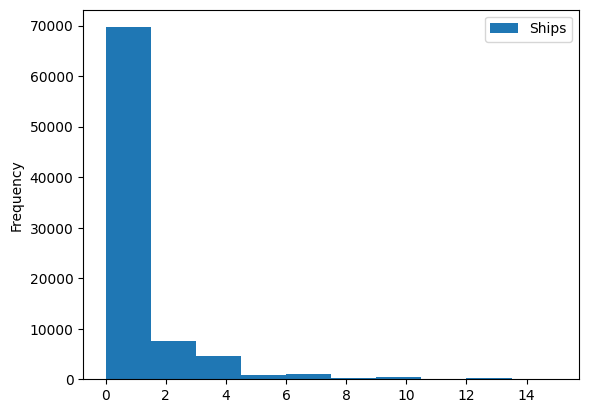

In [19]:
# Let's look at data variance
labels_df[['ImageId', 'Ships']].groupby('ImageId').sum().sort_values(by='Ships').plot(kind='hist');

Basically the images that contain more than 7 are out of the scope and deal trouble to the memory
Solution: Drop them

In [20]:
# Force garbage collector to release unrefferenced memory
gc.collect()

3933

In [21]:
# Drop images with more than 7 ships
num_of_ships_df = labels_df[['ImageId', 'Ships']].groupby('ImageId').sum().sort_values(by='Ships')
num_of_ships_df = num_of_ships_df.drop(num_of_ships_df[num_of_ships_df.Ships>7].index)
num_of_ships_df

Ships
ImageId             
00003e153.jpg      0
63c7b0c22.jpg      0
c2f1fd271.jpg      0
c2f1422a4.jpg      0
63caeebe2.jpg      0
...              ...
6ffdafdec.jpg      7
f905890b8.jpg      7
f8f1f933d.jpg      7
00113a75c.jpg      7
e5f54455d.jpg      7

[83898 rows x 1 columns]

In [22]:
# Delete first empty pic to get even number of batches in future
split_df = labels_df[labels_df.ImageId.isin(num_of_ships_df.index)]
split_df.drop(index=0, inplace=True)
del labels_df
del num_of_ships_df

C:\Users\Sanya\AppData\Local\Temp\ipykernel_9148\3879635137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df.drop(index=0, inplace=True)


In [23]:
%%time
# Grouping by the sums in batches not to overflow the memory
final_df = pd.DataFrame({'ImageId':[], 'Ships': [], 'DecodedPixels':[]})
batches = np.split(split_df, 41)
del split_df
for b in batches:
    final_df = pd.concat([final_df, b.groupby('ImageId').sum()])
    gc.collect()

del batches
img_id = final_df.index.astype('str')
final_df['ImageId'] = img_id
final_df = final_df.groupby('ImageId').sum()
img_id = final_df.index.astype('str')
final_df['ImageId'] = img_id
final_df.reset_index(drop=True, inplace=True)

CPU times: total: 2min 18s
Wall time: 5min 45s


In [24]:
# dataset_df = final_df.sample(20000)
dataset_df = final_df.sample(100)
del final_df
dataset_df.reset_index(drop=True, inplace=True)

In [25]:
# Free some memory to avoid errors
gc.collect()

0

In [26]:
dataset_df

Ships                                      DecodedPixels        ImageId
0     1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  d557a21aa.jpg
1     0.0                                                  0  e3fac1b7f.jpg
2     0.0                                                  0  8cdd2e472.jpg
3     3.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  a368b5692.jpg
4     0.0                                                  0  868ae63f4.jpg
..    ...                                                ...            ...
95    1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  250e8d660.jpg
96    1.0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  4b6656b88.jpg
97    0.0                                                  0  38eca6226.jpg
98    0.0                                                  0  cd1e30b66.jpg
99    0.0                                                  0  65073a2be.jpg

[100 rows x 3 columns]

In [27]:
# Save the modified dataset
dataset_df.to_pickle('dataset_df.pkl')

## Visualization

View of path list: 
['81b1d206d.jpg' 'f20f45356.jpg' 'caecb7b94.jpg' 'dcf2b96e5.jpg'
 'de6a80c2d.jpg' '6c56aea65.jpg' '0a163f5cb.jpg' '1fd8c725c.jpg'
 '3e0a4ccbd.jpg' 'dcc702725.jpg' '383b4dc7f.jpg' 'dbb34d6c2.jpg'
 '566f26baa.jpg' 'b10a64180.jpg' '8a02b374b.jpg' 'ed79d88ca.jpg'
 'a368b5692.jpg' '8f789e5b9.jpg' '162b55631.jpg' 'd4a1b4584.jpg'
 'f66e59c39.jpg' '23c53ace1.jpg' '1d342e7f2.jpg' '21f355982.jpg'
 '1696a45bc.jpg']

Number of images: 25



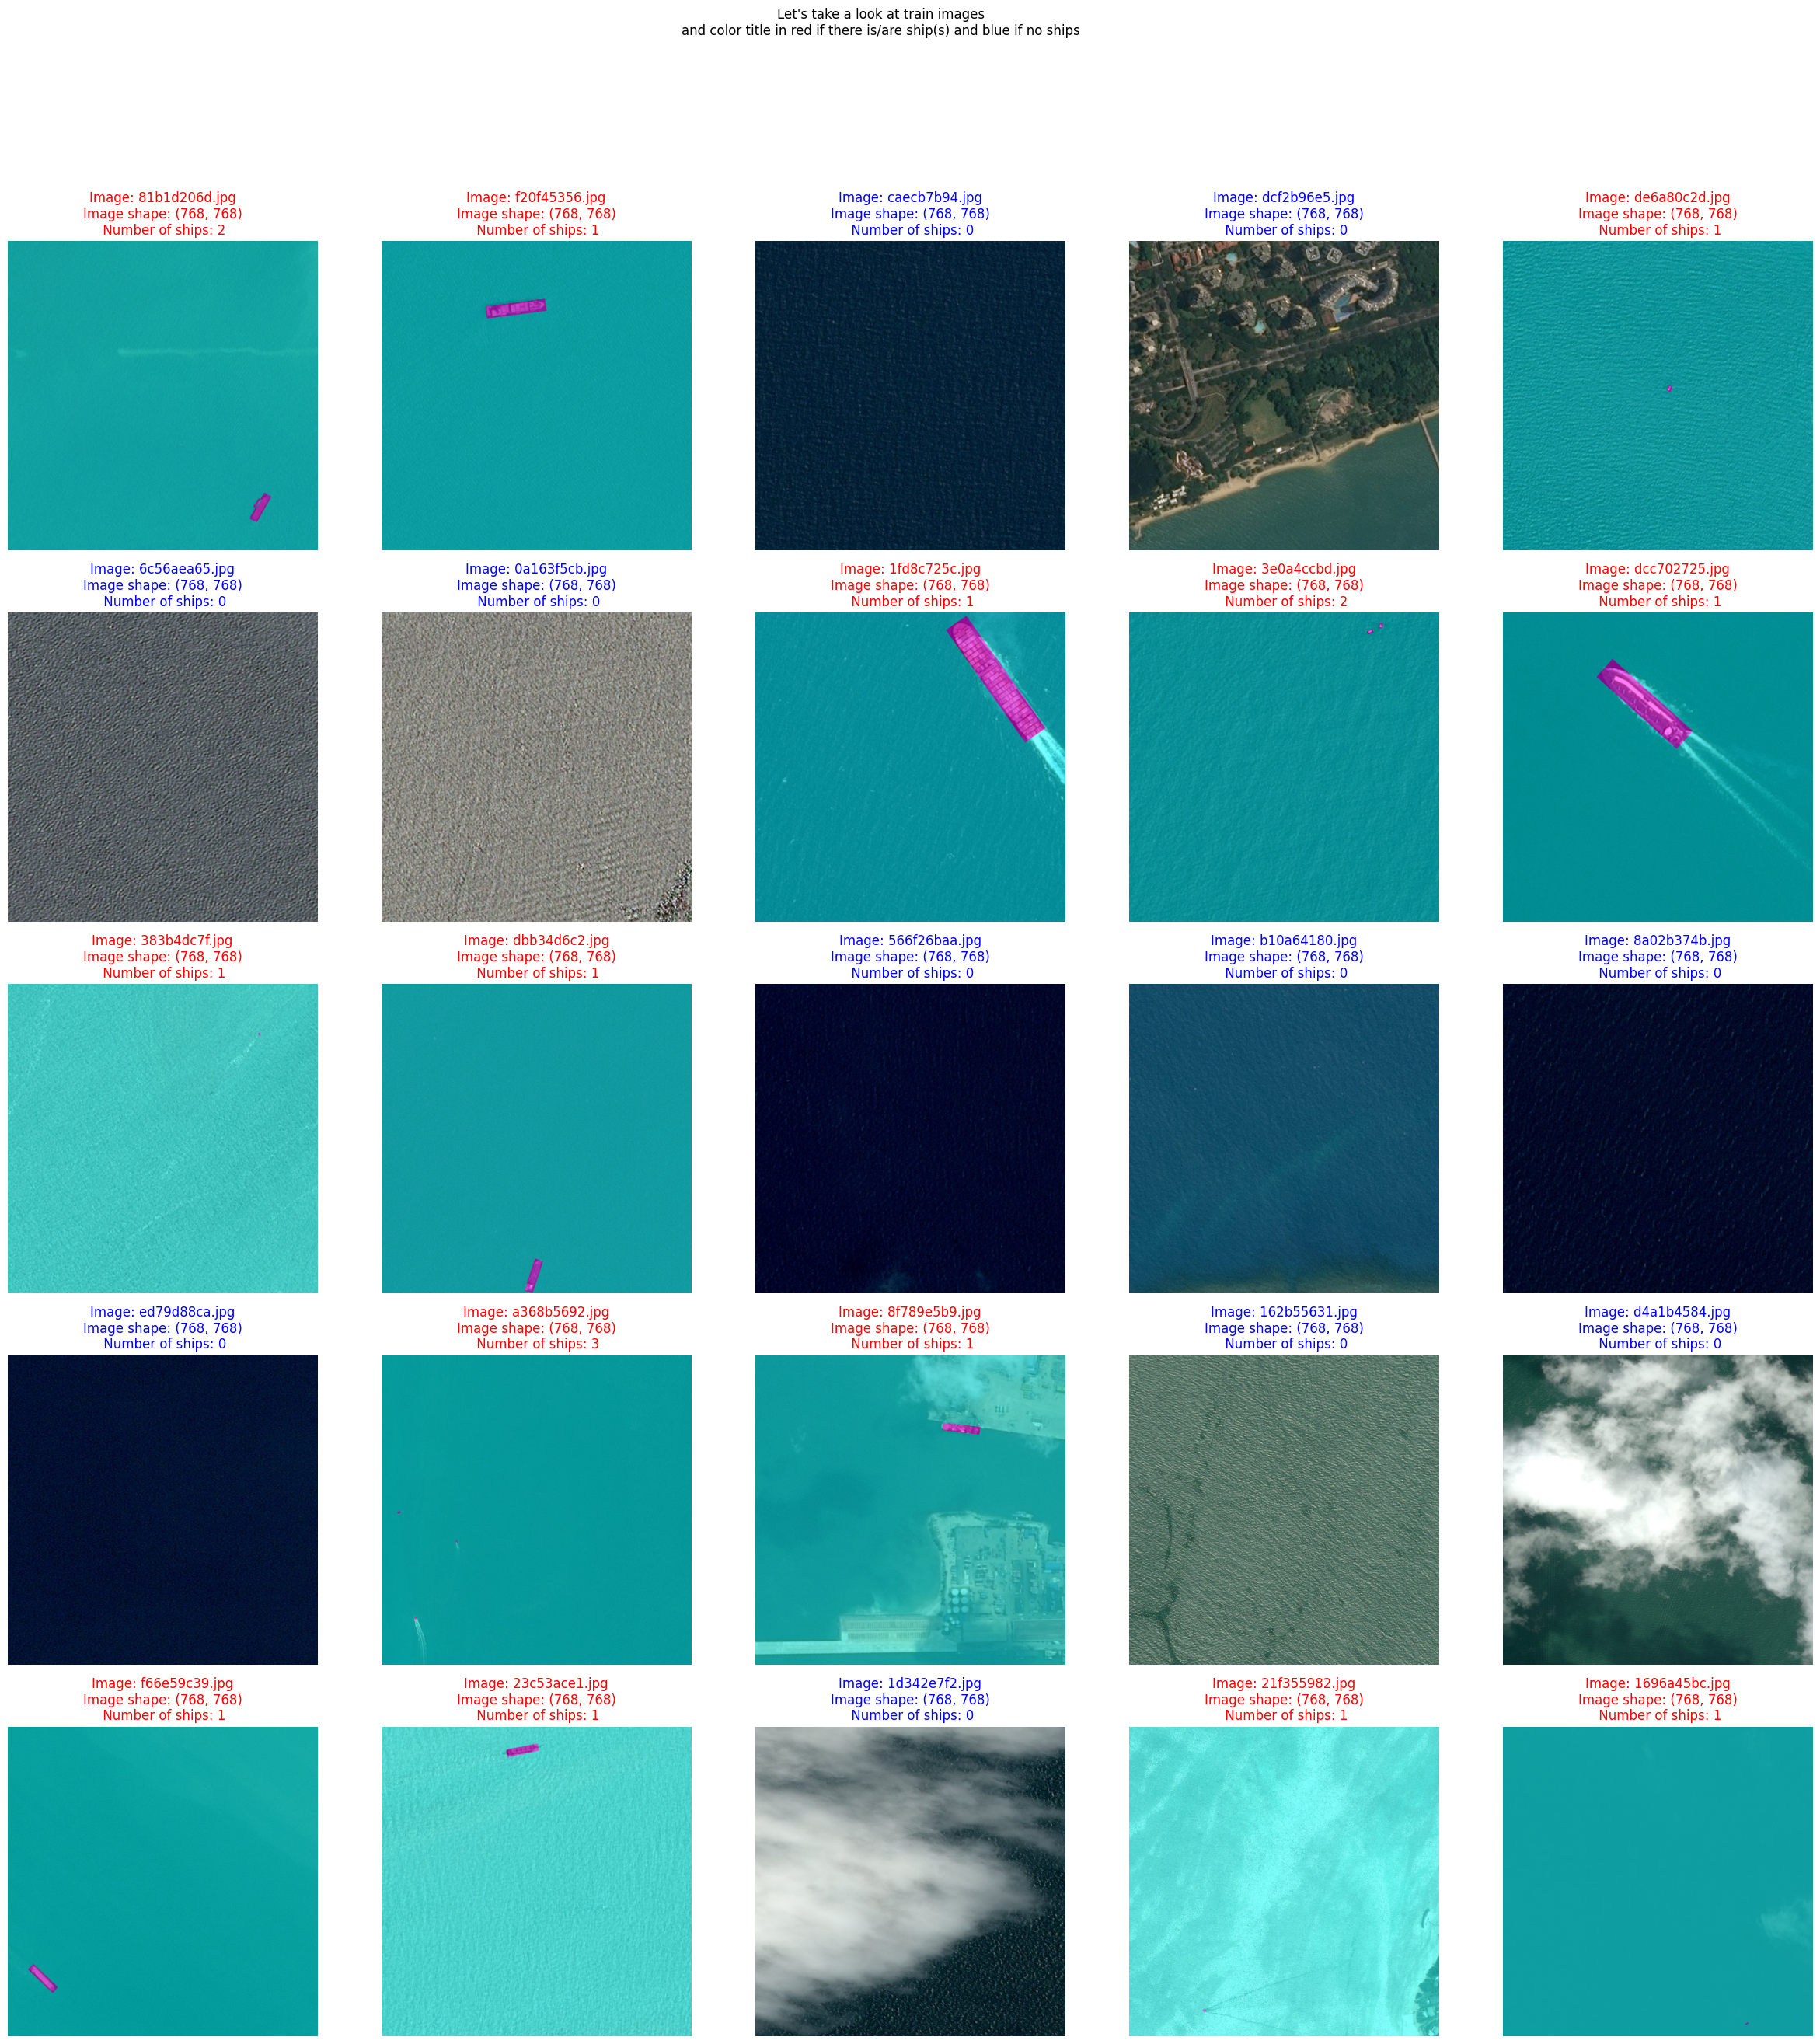

In [28]:
# Get a sample of 9 random images for data visualization
image_sample = dataset_df.ImageId.sample(25)

# Make a list of image id and it's full paths
image_sample = list(map(lambda p: (p, train_folder / p), image_sample))

# Check if everything works
print(f'View of path list: \n{np.array(image_sample).reshape(-1,2)[:,0]}\n')
print(f'Number of images: {len(image_sample)}\n')

# Visualize training images
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Let\'s take a look at train images\nand color title in red if there is/are ship(s) and blue if no ships')
for i, (name, path) in enumerate(image_sample, start=1):
    img = PIL.Image.open(path)
    plt.subplot(5, 5, i)
    color = 'red' if dataset_df[dataset_df.ImageId==name].Ships.item() > 0 else 'blue'  # color will be red if value exists and blue instead
    number_of_ships = '0' if color=='blue' else int(dataset_df[dataset_df.ImageId==name].Ships.item())
    plt.title(f'Image: {name}\nImage shape: {img.size}\n Number of ships: {number_of_ships}', c=color)
    plt.imshow(img)
    if color == 'red':
        plt.imshow(dataset_df[dataset_df.ImageId==name].DecodedPixels.item().reshape(768, 768).T, alpha=0.5, cmap='cool');
    plt.axis(False)

In [29]:
del dataset_df

## Helper functions

In [1]:
%%writefile helper_functions.py
"""
Script contains helpful functions.
Like `rle_decode()` (for pixel decoding)
"""
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras import losses

# ref https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle):
    '''
    Decodes Encoded pixel sequence
    
    Args:
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        
    Returns:
        A numpy array out of 0's and 1's were 1 is the segment that we want to highlight.
        
        Examples:
            "849759324.jpg", 64 -> "[0,1,0,0,0,1,0,0,0,1,...]"

    '''
    if isinstance(mask_rle, float):
        return np.nan
    shape = (768, 768)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.flatten()


def check_memory() -> None:
    """
    Prints out variables and amount of memory they use

    Returns: Prints out a list of memory usage
    """
    local_vars = list(locals().items())
    for var, obj in local_vars:
        print(var, sys.getsizeof(obj))
    

def mormalize(image: np.array):
    """
    Scales image pixels from 0 to 1
    
    Args:
        image: image as numpy array
        
    Returns:
        Normalized imaged form 0 - 1 scale
        Example:
            [122, 125, 245, 234, ...] -> [0.122, 0,125, 0.245, 0.234, ...]
    """
    return tf.cast(image, tf.float32) / 255.0


def augment(input_image: tf.Tensor,
            input_mask: tf.Tensor):
    """
    Randomly preformce image augmentation such as fliping images
    
    Args:
        input_image: TensorFlow tensor
        input_mask: Coresposding to a tensor mask of TensorFlow tensor type
        
    Returns: Flipped tensor
    """
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask


def show_loss(loss_history):
    """
    Plot loss and accuracy curves
    """
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

   
    
def plot_data_balance(df: pd.DataFrame,
                      len_obs: int,
                      miss_labl: int)-> None:
    """
    Plots a bar chart of feature quantities
    
    Args:
        df: Dataframe were currently exploring
        len_obs: Number of all bservations
        miss_labl: Number of mising labels
    
    Returns: None (Creates a barchart to represent variety of features)
    """
    print(f'There are: {len_obs} observations.\n')
    print(f'Missing observations: {miss_labl}\n')
    print(f'The ratio of missed data to all is: {miss_labl/len_obs:.4f}\n')
    print(f'Number of images with ships: {len_obs-miss_labl}\n')

    # Plot the values we get
    data_info = {'data without ships': miss_labl, 'data with a ship': len_obs-miss_labl}
    plt.bar(list(data_info.keys()), list(data_info.values()))
    plt.title('Balance of the dataset.')
    plt.xlabel('type of image')
    plt.ylabel('Quantity')
    plt.show();


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();    

    
def dice_score(y_true, y_pred, smooth=1):
    """
    Segmentation metric of 2 * the Area of Overlap divided by the total number of pixels in both images
    
    Args:
        y_true: Ground truth value, in our case is a mask of the ship
        y_pred: Predicted value in our case the mask that was predicted
        smooth: Parameter that allows to smooth the output
        
    Returns: 1 - the weighted avarege of the overlaps
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    loss = 1 - score
    loss = losses.binary_crossentropy(y_true, y_pred) + loss
    return loss
    

Overwriting helper_functions.py


## Datasets

In [2]:
%%writefile custom_dataset.py
"""
Script turns data into tensorflow dataset + image transformations
"""
import pathlib
from typing import Tuple

import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

train_folder = pathlib.Path(r'./data/train_v2')
test_folder = pathlib.Path(r'./data/test_v2')
save_path = pathlib.Path(r'./data/dataset')

BATCH_SIZE = 32

dataset_df = pd.read_pickle('dataset_df.pkl')

def resize_img(image_name: str) -> np.array:
    """
    Change the size of an image
    
    Args:
        image_name: The name of the image to transform
        mask: Decoded pixel sequence
        
    Returns resized image and mask in a tuple
    """
    image = PIL.Image.open(train_folder / image_name)
    image.thumbnail((128,128))
    
    return np.array(image)


def resize_mask(decode: np.array) -> np.array:
    """
    Change the size of an image
    
    Args:
        image_name: The name of the image to transform
        mask: Decoded pixel sequence
        
    Returns resized image and mask in a tuple
    """
    if decode is 0:
        return np.zeros(shape=(128, 128))
    mask = PIL.Image.fromarray(decode.reshape(768, 768).T)
    mask.thumbnail((128,128))
    
    return np.array(mask)


features = tf.convert_to_tensor(list(dataset_df.ImageId.apply(resize_img)))
labels = tf.convert_to_tensor(list(dataset_df.DecodedPixels.apply(resize_mask)))
labels = tf.expand_dims(labels, axis=-1)
labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Create a tensorflow dataset
ships_dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(32)

train_threshold = 0.8
train_size = int(len(ships_dataset) * train_threshold)

train_data = ships_dataset.take(train_size)
test_data = ships_dataset.skip(train_size)

Overwriting custom_dataset.py


## Model

In [3]:
%%writefile model.py

"""
This python script contains a unet architecture neural network  
"""
from typing import Tuple

import tensorflow as tf
from tensorflow.keras import models, layers

def double_conv_block(x: tf.Tensor,
                      n_filters: int):
    """
    Passes inputs through 2 conv2d and ReLU activation layers
    Conv block -> Conv block
    
    Args:
        x: TensorFlow tensor we pass through
        n_filters: number of filters we want conv layer to use
        
    Returns: A tensor that was modified by the layers in this function
    """
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)

    return x


def downsample_block(x: tf.Tensor,
                     n_filters:int):
    """
    Block that will perform a downsampling operation
    Double_Conv block -> MaxPool(window size 2) -> Dropout(probability 0.3)
    
    Args:
        x: TensorFlow tensor we pass through
        n_filters: number of filters we want conv layer to use
        
    Returns: A tensor that was modified by the layers in this function
    """
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    
    return f, p

def upsample_block(x: tf.Tensor,
                   conv_features: tf.Tensor,
                   n_filters:int):
    """
    Block that will perform a upsampling operation
    Conv Transpose (Unconv) block -> concatenate -> Dropout -> Double_Conv
    
    Args:
        x: TensorFlow tensor we pass through
        conv_features: Tensor which will be concatenated with the one we passed as x
        n_filters: number of filters we want conv layer to use
    
    Returns: A tensor that was modified by the layers in this function
    """
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    
    return x
    
def build_unet_model(input_shape: Tuple[int, int, int]):
    """
    Returns a U-net architecture neural network model
    
    Args:
        x: TensorFlow tensor we pass through
        conv_features: Tensor which will be concatenated with the one we passed as x
        n_filters: number of filters we want conv layer to use
   
    Returns: A U-net architecture model
    """
    # inputs
    inputs = layers.Input(shape=input_shape)

    # encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # outputs
    outputs = layers.Conv2D(3, 1, padding='same', activation='softmax')(u9)
    
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name='U-net')
        
    return unet_model

Overwriting model.py


## Model Training

In [4]:
%%writefile train_u_net.py
"""
This script trains the model
"""
import pathlib
import tensorflow as tf
from model import build_unet_model
from helper_functions import dice_score, plot_loss_curves
from custom_dataset import train_data, test_data

# Instantiate model
model_0 = build_unet_model(input_shape=(128, 128, 3))

# Compile model
model_0.compile(optimizer=tf.keras.optimizers.SGD(),
                loss=dice_score,
                metrics=['accuracy'])

# Setup hyperparameter
epochs=5
batch_size = 1

# Train the model
model_history = model_0.fit_generator(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data))

plot_loss_curves(model_history)

model_0.evaluate(test_data)

save_path = 'ships_prediction_model'
model_0.save(save_path)

Overwriting train_u_net.py


Enter your image path 00fa68a59
1/1 [==============================] - 0s 111ms/step


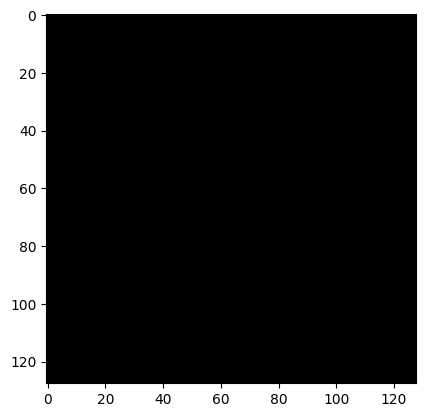

In [9]:
# %%writefile inference.py
"""
File makes inference on the test folder by given image name from test file
"""
import pathlib
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from helper_functions import dice_score, plot_loss_curves
from train_u_net import save_path, model_0

test_folder = pathlib.Path(r'./data/test_v2')

def resize_img(image_name: str) -> np.array:
    """
    Change the size of an image
    
    Args:
        image_name: The name of the image to transform
        mask: Decoded pixel sequence
        
    Returns resized image and mask in a tuple
    """
    image = PIL.Image.open(image_name)
    image.thumbnail((128,128))
    
    return tf.convert_to_tensor(image)

inference_path = input('Enter your image path ') + '.jpg'
test_image = resize_img(test_folder / inference_path)

fig = plt.figure()
plt.imshow(model_0.predict(tf.expand_dims(test_image, axis=0)).reshape(128, 128, 3))
